## Confidentiality

The programmatic cases in this notebook are utilized from different internet resources (in this notebook especially from kaggle.com) and are for demonstrational purposes only.

Please do not copy or distribute this notebook.

## Table of content

Census Income Data

1. Programmatic case 1 
2. Programmatic case 2

## Previous knowledge

For a good understanding of this notebook you should have a few years of data-science and programming experience and have studied the advanced programming notebooks.

#### Programmatic case 1

In [ ]:
######################################################################################################################
######################################################################################################################
##2) Prediction 1 - Advanced Program 

#2.1) LGBM Ensemble

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split

# Regularized Greedy Forest
!pip install rgf_python -v
from rgf.sklearn import RGFClassifier     # https://github.com/fukatani/rgf_python

import datetime
import pandas as pd
import xgboost as xgb
import numpy as np
import json, math, os, sys

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion, make_pipeline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data


census_data_filename = './adult.data'

# These are the column labels from the census data files
COLUMNS = (
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'Clothing',
    'Gender',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income-level'
)

# Loading the training census dataset
with open(census_data_filename, 'r') as train_data:
    raw_training_data = pd.read_csv(train_data, header=None, names=COLUMNS)

# Class 1: Pre-processing
raw_training_data.head()

train = raw_training_data.drop('income-level', axis=1).values
# Creating training labels list
target_train = (raw_training_data['income-level'] == ' >50K').values

target_train, bin= train_test_split(target_train, train_size=0.70)


# Class 1.1 Positionalselector
class PositionalSelector(BaseEstimator, TransformerMixin):
    def __init__(self, positions):
        self.positions = positions

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:, self.positions]

# Class 1.2 CleanString
class CleanString(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        strip = np.vectorize(str.strip)
        return strip(np.array(X))

# Class 1.3 SimpleOneHotEncoder
class SimpleOneHotEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.values = []
        for c in range(X.shape[1]):
            Y = X[:, c]
            values = {v: i for i, v in enumerate(np.unique(Y))}
            self.values.append(values)
        return self

    def transform(self, X):
        X = np.array(X)
        matrices = []
        for c in range(X.shape[1]):
            Y = X[:, c]
            matrix = np.zeros(shape=(len(Y), len(self.values[c])), dtype=np.int8)
            for i, x in enumerate(Y):
                if x in self.values[c]:
                    matrix[i][self.values[c][x]] = 1
            matrices.append(matrix)
        res = np.concatenate(matrices, axis=1)
        return res

# Class 1.4 Makepipeline

# Categorical features: age and hours-per-week
# Numerical features: workclass, marital-status, and relationship
numerical_indices = [0, 12]  # age-num, and hours-per-week
categorical_indices = [1, 3, 5, 7]  # workclass, education, marital-status, and relationship

p1 = make_pipeline(PositionalSelector(categorical_indices), 
                   StripString(), 
                   SimpleOneHotEncoder())
p2 = make_pipeline(PositionalSelector(numerical_indices), 
                   StandardScaler())

pipeline = FeatureUnion([
    ('numericals', p1),
    ('categoricals', p2),
])

train_features = pipeline.fit_transform(raw_features)

train, test= train_test_split(train_features, train_size=0.70)
print(train.shape, test.shape)


# Class 2: Ensembling

# Class 2.1 Ensemble
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                # y_holdout = y[test_idx]

                print ("Fit %s fold %d" % (str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                # cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                # print("    cross_score: %.5f" % (cross_score.mean()))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        print("Stacker score: %.5f" % (results.mean()))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

# Class 4.2 Parameters
# LightGBM params
lgb_params = {}
lgb_params['learning_rate'] = 0.02
lgb_params['n_estimators'] = 650
lgb_params['max_bin'] = 10
lgb_params['subsample'] = 0.8
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.8   
lgb_params['min_child_samples'] = 500
lgb_params['seed'] = 99

lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 99

lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 99


lgb_model = LGBMClassifier(**lgb_params)

lgb_model2 = LGBMClassifier(**lgb_params2)

lgb_model3 = LGBMClassifier(**lgb_params3)


log_model = LogisticRegression()

        
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (lgb_model, lgb_model2, lgb_model3))        
        
y_pred = stack.fit_predict(train, target_train, test)        


sub = pd.DataFrame()
sub['target'] = y_pred
sub.to_csv('stacked_1.csv', index=False)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Created temporary directory: /tmp/pip-ephem-wheel-cache-KS6hmN
Created temporary directory: /tmp/pip-req-tracker-lFNQc8
Created requirements tracker '/tmp/pip-req-tracker-lFNQc8'
Created temporary directory: /tmp/pip-install-apYLUO
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker-lFNQc8'
--2021-02-04 21:16:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.7’

adult.data.7        100%[===================>]   3.79M  8.17MB/s    in 0.5s    

2021-02-04 21:16:44 (8.17 MB/s) - ‘adult.data.7’ saved [3974305/3974305]

((22792, 40), (9769, 40))
Fit LGBMClassifier fold 1
Fit LGBMClassifier fold 2
Fi

In [1]:
######################################################################################################################
######################################################################################################################
##2) Prediction 2 - Advanced Program 

#2.2) Tensorflow linear classifier

W0204 21:05:11.512485 139927220172672 estimator.py:453] Using temporary folder as model directory: /tmp/tmpyRXKm_


Training model...


W0204 21:05:13.159636 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:13.507635 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:13.583390 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:05:13.609266 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 00 : 0.559


W0204 21:05:22.419166 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:22.531966 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:22.603458 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:05:22.632589 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 01 : 0.534


W0204 21:05:31.242727 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:31.353573 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:31.424329 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:05:31.451415 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 02 : 0.523


W0204 21:05:39.914318 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:40.028925 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:40.106348 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:05:40.133035 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 03 : 0.516


W0204 21:05:48.584543 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:48.689382 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:48.765646 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:05:48.792331 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 04 : 0.510


W0204 21:05:56.970166 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:57.074179 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:05:57.145797 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:05:57.173721 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 05 : 0.506


W0204 21:06:05.326165 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:05.434211 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:05.506448 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:06:05.530247 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 06 : 0.502


W0204 21:06:13.572417 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:13.680797 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:13.750348 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:06:13.776886 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 07 : 0.499


W0204 21:06:22.182533 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:22.293140 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:22.368639 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:06:22.394584 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 08 : 0.496


W0204 21:06:38.881663 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:38.993794 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:39.071837 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:06:39.097909 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 09 : 0.494
Final Training Loss: 0.494
Final Validation Loss: 0.502


W0204 21:06:47.693562 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:47.805613 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:47.873687 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:06:47.898344 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:06:49.340368 139927220172672 estimator.py:453] Using temporary folder as model directory: /tmp/tmpc3brvz


AUC on the validation set: 0.74
Accuracy on the validation set: 0.75
Loss on the validation set: 0.50
Training model...


W0204 21:06:51.317523 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:51.426718 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:51.498826 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:06:51.524127 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 00 : 0.607


W0204 21:06:59.795836 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:06:59.904536 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:00.189842 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:07:00.215297 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 01 : 0.570


W0204 21:07:08.250391 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:08.359266 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:08.431482 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:07:08.457706 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 02 : 0.552


W0204 21:07:16.602468 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:16.711709 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:16.781687 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:07:16.810719 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 03 : 0.541


W0204 21:07:24.788881 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:24.897382 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:25.183864 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:07:25.209064 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 04 : 0.534


W0204 21:07:33.252101 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:33.359052 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:33.432710 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:07:33.460061 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 05 : 0.529


W0204 21:07:41.707757 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:41.815435 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:41.886065 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:07:41.911423 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 06 : 0.525


W0204 21:07:49.897733 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:50.006944 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:50.079426 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:07:50.106018 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 07 : 0.522


W0204 21:07:58.256887 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:58.378849 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:07:58.456022 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:07:58.481261 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 08 : 0.519


W0204 21:08:06.673074 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:08:06.780071 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:08:06.861144 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:08:06.889655 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


  Training loss after period 09 : 0.516
Final Training Loss: 0.516
Final Validation Loss: 0.525


W0204 21:08:14.824256 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:08:14.934521 139927220172672 head.py:2027] Casting <dtype: 'int64'> labels to bool.
W0204 21:08:15.011785 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0204 21:08:15.035856 139927220172672 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


AUC on the validation set: 0.71
Accuracy on the validation set: 0.75
Loss on the validation set: 0.53


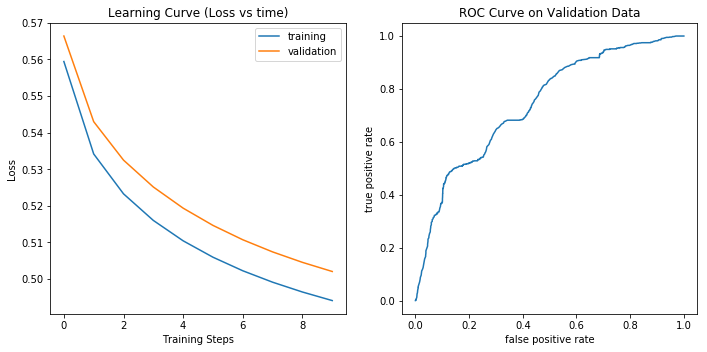

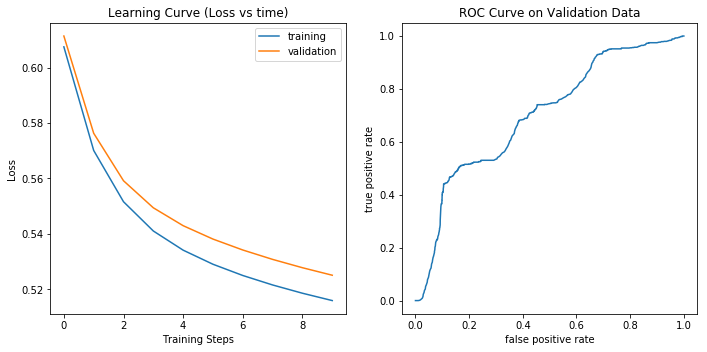

In [ ]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics

!pip install tensorflow
!pip install tensorflow_gpu
!pip install "tensorflow==1.14.0"
!pip install "tensorflow_gpu==1.14.0"
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator

# Increasing the amount of logging when there is an error
tf.logging.set_verbosity(tf.logging.ERROR)

# Setting the output display to have two digits for decimal places, for display
# readability only and limit it to printing 10 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 20

import tempfile
import urllib
train_file = tempfile.NamedTemporaryFile()
urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", train_file.name)

COLUMNS = ["age", "workclass", "sample_weight", "education", "education_num",
           "marital_status", "occupation", "relationship", "clothing", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]
census_df = pd.read_csv(train_file, names=COLUMNS, skipinitialspace=True)
# Presenting first 5 rows of the table.
census_df.head(5)


CATEGORICAL_COLUMNS = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "clothing", "gender", "native_country"]
NUMERICAL_COLUMNS = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]
LABEL = "income_over_50k"

def input_fn(dataframe):
  """Constructs a dictionary for the feature columns.

  Args:
    dataframe: The Pandas DataFrame to use for the input.
  Returns:
    The feature columns and the associated labels for the provided input.
  """
  # Creating a dictionary mapping each numerical feature column name (k) to
  # the values of that column stored in a constant Tensor.
  numerical_cols = {k: tf.constant(dataframe[k].values) 
                    for k in NUMERICAL_COLUMNS}
  # Creating a dictionary mapping each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(dataframe[k].size)],
      values=dataframe[k].values,
      dense_shape=[dataframe[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merging the two dictionaries into one.
  feature_cols = dict(numerical_cols.items() + categorical_cols.items())
  # Converting the label column into a constant Tensor.
  label = tf.constant(dataframe[LABEL].values)
  # Returning the feature columns and the label.
  return feature_cols, label

def train_input_fn():
  return input_fn(training_examples)

def eval_input_fn():
  return input_fn(validation_examples)

def test_input_fn():
  return input_fn(test_examples)


# Linearly rescaling to the range [0, 1]
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = 1.0 * (max_val - min_val)
  return series.apply(lambda x:((x - min_val) / scale))

def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain the data.
  Returns:
    A new DataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  for feature in NUMERICAL_COLUMNS:
    processed_features[feature] = linear_scale(dataframe[feature])
    
  # Converting the output target to 0 (for <=50k) and 1 (> 50k)
  processed_features[LABEL] = dataframe["income_bracket"].apply(
      lambda x: ">50K" in x).astype(int)
  
  return processed_features


census_df = census_df.reindex(np.random.permutation(census_df.index))
training_examples = prepare_features(census_df.head(12281))
validation_examples = prepare_features(census_df.tail(4000))

test_file = tempfile.NamedTemporaryFile()
urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", test_file.name)

census_df_test = pd.read_csv(test_file, names=COLUMNS, skipinitialspace=True, skiprows=1)
test_examples = prepare_features(census_df_test)


def make_roc_curve(predictions, targets):
  """ Plots an ROC curve for the provided predictions and targets.

  Args:
    predictions: the probability that the example has label 1.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
  """  
  false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
      targets, predictions)
  
  plt.ylabel("true positive rate")
  plt.xlabel("false positive rate")
  plt.plot(false_positive_rate, true_positive_rate)

  
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of training losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)


def compute_loss(model, input_fn, targets):
  """ Computes the log loss for training a linear classifier.
  
  Args:
    model: the trained model to use for making the predictions.
    input_fn: the input_fn to use to make the predicitons.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
    
  Returns:
    The log loss for the provided predictions and targets.
  """      
  
  predictions = np.array(list(model.predict_proba(input_fn=input_fn)))
  return metrics.log_loss(targets, predictions[:, 1])


def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns.
  """
  
  # Sample creating a categorical column with known values.
  gender = tf.contrib.layers.sparse_column_with_keys(
    column_name="gender", keys=["Female", "Male"])
  
  # Sample creating a categorical columns with a hash bucket.    
  education = tf.contrib.layers.sparse_column_with_hash_bucket(
      "education", hash_bucket_size=50)
  
  # Sample creating a real-valued column for numeric data.
  age = tf.contrib.layers.real_valued_column("age") 

  # Returning the set of all feature columns generated.
  feature_columns=[gender, education, age]
 
  return feature_columns


def define_linear_classifier(learning_rate):
  """ Defines a linear classifer to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate.
    
  Returns:
    A linear classifier created with the given parameters.
  """
  linear_classifier = tf.contrib.learn.LinearClassifier(
    feature_columns=construct_feature_columns(),
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
    gradient_clip_norm=5.0
  )  
  return linear_classifier


def train_model(model, steps):
  """Trains a linear classifier.
  
  Args:
    model: The model to train.
    steps: A non-zero `int`, the total number of training steps.
    
  Returns:
    The trained model.
  """
  # In order to see how the model evolves as it is trained, the steps
  # are divided into periods and presents the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Training the model, but doing so inside a loop so that you can periodically assess
  # loss metrics.  Storing the training and validation losses so you can
  # generate a learning curve.
  print "Training model..."
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Calling fit to train the model for steps_per_period steps.
    model.fit(input_fn=train_input_fn, steps=steps_per_period)
    
    # Computing the loss between the predictions and the correct labels, appending
    # the training and validation loss to the list of losses used to generate
    # the learning curve after training is complete and printing the current
    # training loss.
    training_loss = compute_loss(model, train_input_fn,
                                 training_examples[LABEL])
    validation_loss = compute_loss(model, eval_input_fn,
                                   validation_examples[LABEL])
    training_losses.append(training_loss) 
    validation_losses.append(validation_loss) 
    print "  Training loss after period %02d : %0.3f" % (period, training_loss)
      
  # Now that training is done, printing the final training and validation losses.  
  print "Final Training Loss: %0.3f" % training_loss
  print "Final Validation Loss: %0.3f" % validation_loss 
  
  # Generating a figure with the learning curve on the left and an ROC curve on
  # the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (Loss vs time)")
  plot_learning_curve(training_losses, validation_losses)
  
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0) 
  plt.title("ROC Curve on Validation Data")
  validation_probabilities = np.array(list(model.predict_proba(
    input_fn=eval_input_fn)))
  # ROC curve uses the probability that the label is 1.
  make_roc_curve(validation_probabilities[:, 1], validation_examples[LABEL])
   
  return model


LEARNING_RATE = 0.1
STEPS = 250

linear_classifier = define_linear_classifier(learning_rate = LEARNING_RATE)
linear_classifier = train_model(linear_classifier, steps=STEPS)


evaluation_metrics = linear_classifier.evaluate(
 input_fn=eval_input_fn, steps=1)

print "AUC on the validation set: %0.2f" % evaluation_metrics['auc']
print "Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy']
print "Loss on the validation set: %0.2f" % evaluation_metrics['loss']


def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns.
  """
  
  # Sample creating a categorical column with known values.
  gender = tf.contrib.layers.sparse_column_with_keys(
    column_name="gender", keys=["Female", "Male"])
  
  # Sample creating a categorical columns with a hash bucket.    
  education = tf.contrib.layers.sparse_column_with_hash_bucket(
      "education", hash_bucket_size=50)
  
  # Sample creating a real-valued column that can be used for numerical data.
  age = tf.contrib.layers.real_valued_column("age") 

  # Returning the set of all feature columns generated.
  feature_columns=[gender, education, age]
 
  return feature_columns

LEARNING_RATE = 0.1
STEPS = 100

linear_classifier = define_linear_classifier(learning_rate = LEARNING_RATE)
linear_classifier = train_model(linear_classifier, steps=STEPS)


evaluation_metrics = linear_classifier.evaluate(
 input_fn=eval_input_fn, steps=1)

print "AUC on the validation set: %0.2f" % evaluation_metrics['auc']
print "Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy']
print "Loss on the validation set: %0.2f" % evaluation_metrics['loss']